# IMPORT MODULE

In [1]:
ls

2022_wenig_timeeval.pdf                 main2.ipynb
TravelTime_451.csv                      nyc_taxi.csv
Twitter_volume_UPS.csv                  output_gtg/
ambient_temperature_system_failure.csv  readme.md
config_gtg.yaml                         requirements.txt
cpu.csv                                 results/
datasets.csv                            results_cleared/
datasets_from_gutentag/                 test.py
machine_temperature_system_failure.csv  timeeval-datasets/
main.ipynb                              timeeval.log


In [2]:
!pip install -r requirements.txt
!pip install prophet
!pip install seaborn
!pip install keras
!pip install tensorflow

  Using cached cmdstanpy-1.2.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached holidays-0.40-py3-none-any.whl.metadata (21 kB)
  Using cached stanio-0.3.0-py3-none-any.whl.metadata (963 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 17.0 MB/s eta 0:00:00a 0:00:01
Using cached cmdstanpy-1.2.0-py3-none-any.whl (93 kB)
Using cached holidays-0.40-py3-none-any.whl (889 kB)
Using cached stanio-0.3.0-py3-none-any.whl (6.2 kB)
  Using cached seaborn-0.13.1-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.1-py3-none-any.whl (294 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Using cached absl_py-2.0.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cache

In [3]:
import pandas as pd
import requests
from io import StringIO
import numpy as np 
import matplotlib.pyplot as plt
import adtk
from  adtk.data import validate_series
import matplotlib.style
%matplotlib inline
import kneed 
from sklearn.neighbors import LocalOutlierFactor
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
import sklearn 
from sklearn.metrics import mean_absolute_error , mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import keras
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy.stats import median_abs_deviation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from adtk.detector import ThresholdAD
from adtk.detector import QuantileAD
from adtk.detector import InterQuartileRangeAD

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---

# IMPORT DATA SET

We will evaluate our models on the basis of different time series. The explination of this data set will be presented in the rapport

In [4]:
def importdataset(file):
    dataset = pd.read_csv(file)
    return dataset

In [5]:
cpu_data = importdataset("cpu.csv")
twitter_data = importdataset("Twitter_volume_UPS.csv")
taxi_data = importdataset("nyc_taxi.csv")
machine_data = importdataset("machine_temperature_system_failure.csv")
ambiant_data = importdataset("ambient_temperature_system_failure.csv")
travel_data = importdataset("TravelTime_451.csv")

In [6]:
anomalies_cpu = [
        "2014-02-26 22:05:00",
        "2014-02-27 17:15:00"
    ]

anomalies_ambiant = [
        "2013-12-22 20:00:00",
        "2014-04-13 09:00:00"
    ]

anomalie_machine = [
        "2013-12-11 06:00:00",
        "2013-12-16 17:25:00",
        "2014-01-28 13:55:00",
        "2014-02-08 14:30:00"
    ]


anomalie_taxi = [
            "2014-10-30 15:30:00",
            "2014-11-03 22:30:00",
            "2014-11-25 12:00:00",
            "2014-11-29 19:00:00",
            "2014-12-23 11:30:00",
            "2014-12-27 18:30:00",
            "2014-12-29 21:30:00",
            "2015-01-03 04:30:00",
            "2015-01-24 20:30:00",
            "2015-01-29 03:30:00"
        ]


anomalie__twitter =  [
        "2015-03-03 00:27:53",
        "2015-03-04 11:07:53",
        "2015-03-05 15:22:53",
        "2015-03-24 18:17:53",
        "2015-03-29 16:27:53"
    ]

anomalie_traval = [
    "2015-08-11 21:32:00.000000"
    ]


---

# Pre processing

In [7]:
def timestamp(df):   #Transform the data set in order to have a correct timestamp by transofrming the / into -
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df


In [8]:
def label(df, anomalies_timestamp):
    # Initially set all rows to non-anomaly
    df['is_anomaly'] = 1

    # Loop through each anomaly timestamp
    for each in anomalies_timestamp:
        # Use .loc for proper conditional indexing
        df.loc[df['timestamp'] == each, 'is_anomaly'] = -1
    
    return df

---

# Vizualisation

In [9]:
def visualisation(df):
    anomaly_df = df[df['is_anomaly'] == -1]
    inlier_df = df[df['is_anomaly'] == 1]
    fig, ax = plt.subplots()

    ax.scatter(inlier_df['timestamp'], inlier_df['value'], color='blue', s=3, label='Inlier')
    ax.scatter(anomaly_df['timestamp'], anomaly_df['value'], color='red', label='Anomaly')
    ax.set_xlabel('Time')

    ax.legend(loc=2)

    plt.grid(False)
    fig.autofmt_xdate()
    plt.tight_layout()

---

# Stationarity Hypothesis 

One key element that is often used when dealing with time series is the stationarity hypothesis

In [10]:
def is_time_series_stationary(df):
    # Perform Dickey-Fuller test:
    result = adfuller(df['value'])
    adf_statistic = result[0]
    p_value = result[1]
    if p_value < 0.05:
            return True
    else:
        return False

---

# Specific Data Set

Some algorithms such as ATDK and LSTM requires a specific format of the data. Indeed to work in the univariate case. The data should be a in serie format where the timestamp is the index

In [11]:
def serie(df):
    new_df = df.copy()
    new_df = new_df.set_index('timestamp')
    columns_to_drop = [col for col in new_df.columns if col != 'value']
    new_df = new_df.drop(columns=columns_to_drop)
    return new_df

---

# MODELS

---

# LSTM

In [12]:
def train_test(df):
    train_size = int(len(df) * 0.95)
    train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
    return(train, test)

In [13]:
def standard(train, test):
    scaler = StandardScaler()
    scaler = scaler.fit(train[['value']])

    # Use .loc to avoid SettingWithCopyWarning
    train.loc[:, 'value'] = scaler.transform(train[['value']])
    test.loc[:, 'value'] = scaler.transform(test[['value']])

    return train, test

In [14]:
def create_dataset(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [15]:
def create_and_train_lstm_model(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, shuffle=False):
    """
    Create and train an LSTM model using the given training data.

    Parameters:
    X_train (np.array): Input features for training.
    y_train (np.array): Target values for training.
    epochs (int): Number of epochs to train the model.
    batch_size (int): Batch size for training.
    validation_split (float): Fraction of the training data to be used as validation data.
    shuffle (bool): Whether to shuffle the training data before each epoch.

    Returns:
    keras.models.Sequential: The trained LSTM model.
    keras.callbacks.History: Training history object.
    """
    # Create the LSTM model
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=64, input_shape=input_shape))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.RepeatVector(n=input_shape[0]))
    model.add(keras.layers.LSTM(units=64, return_sequences=True))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=input_shape[1])))
    model.compile(loss='mae', optimizer='adam')

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        shuffle=shuffle
    )

    return model, history


In [16]:
def detect_anomalies_and_plot(X_test, model, test_df, TIME_STEPS, threshold=0.65):
   
    # Predict on X_test
    X_test_pred = model.predict(X_test)

    # Calculate MAE loss
    test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

    # Create a DataFrame for the test score
    test_score_df = pd.DataFrame(index=test_df[TIME_STEPS:].index)
    test_score_df['loss'] = test_mae_loss
    test_score_df['threshold'] = threshold
    test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
    test_score_df['close'] = test_df[TIME_STEPS:].close

    # Plotting
    plt.plot(test_score_df.index, test_score_df.loss, label='loss')
    plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
    plt.xticks(rotation=25)
    plt.legend()
    plt.show()

    return test_score_df

In [17]:
def detect_anomalies(X_test, model, test_df, TIME_STEPS, threshold=0.65):
    # Predict on X_test
    X_test_pred = model.predict(X_test)

    # Calculate MAE loss
    test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

    # Create a DataFrame for the test score
    test_score_df = pd.DataFrame(index=test_df[TIME_STEPS:].index)
    test_score_df['loss'] = test_mae_loss
    test_score_df['threshold'] = threshold
    test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
    test_score_df['value'] = test_df[TIME_STEPS:].value

    # Update 'anomaly' column to have 1 for anomalies and -1 for normal points
    test_score_df['anomaly'] = test_score_df['anomaly'].apply(lambda x: -1 if x else 1)

    # Return the test score DataFrame
    return test_score_df


In [18]:
def plot_loss(test_score_df):
    plt.plot(test_score_df.index, test_score_df.loss, label='loss')
    plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
    plt.xticks(rotation=25)
    plt.legend()
    plt.show()


In [19]:
def mark_ground_truth(df, anomalies):
    # Convert anomalies list to a set for faster lookup
    anomalies_set = set(anomalies)

    # Create 'ground_truth' column, -1 for anomalies, 1 for normal data
    df['ground_truth'] = df.index.map(lambda x: -1 if x in anomalies_set else 1)

    return df


In [20]:
def print_confusion_matrix_metrics_lm(df):
    # Extract ground_truth and anomaly columns
    y_true = df['ground_truth']
    y_pred = df['anomaly']

    # Calculate confusion matrix
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()

    # Calculate recall (sensitivity)
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0

    # Calculate specificity
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

    # Print the results
    print("Confusion Matrix:")
    print(f"True Negatives (TN): {TN}")
    print(f"False Positives (FP): {FP}")
    print(f"False Negatives (FN): {FN}")
    print(f"True Positives (TP): {TP}")
    print(f"Recall (Sensitivity): {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")


---

# MAD

In [21]:
def isnormal(df):

    sns.kdeplot(df['value']);
    plt.grid(False)
    plt.axvline(0.134, 0, 1, c='black', ls='--')
    plt.tight_layout()

In [22]:
def add_robust_z_score_column(data):
    # Calculate the median of the column
    df = data.copy()
    median = df['value'].median()

    # Calculate the Median Absolute Deviation (MAD)
    mad = np.median(np.abs(df['value'] - median))

    # Calculate the robust Z-score and add it as a new column
    df['z-score'] = 0.6745 * (df['value'] - median) / mad if mad else 0

    return df


In [23]:
def anomaly_predicted(df):
    # Initialize 'anomaly_predicted' to 1 (normal) for all rows
    df['anomaly_predicted'] = 1

    # Mark as -1 (anomaly) where z-score is >= 3.5 or <= -3.5
    df.loc[df['z-score'] >= 3.5, 'anomaly_predicted'] = -1
    df.loc[df['z-score'] <= -3.5, 'anomaly_predicted'] = -1

    return df

In [24]:
def confusion_metrics(df):
    # Extract ground_truth and anomaly columns
    y_true = df['is_anomaly']
    y_pred = df['anomaly_predicted']

    # Calculate confusion matrix
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()

    # Calculate recall (sensitivity)
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0

    # Calculate specificity
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

    # Print the results
    print("Confusion Matrix:")
    print(f"True Negatives (TN): {TN}")
    print(f"False Positives (FP): {FP}")
    print(f"False Negatives (FN): {FN}")
    print(f"True Positives (TP): {TP}")
    print(f"Recall (Sensitivity): {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")

In [25]:
def plot_confusion_matrix(df):
    # Compute the confusion matrix
    cm = confusion_matrix(df['is_anomaly'], df['anomaly_predicted'], labels=[1, -1])

    # Create the confusion matrix display object
    disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

    # Plot the confusion matrix
    disp_cm.plot()
    plt.grid(False)
    plt.tight_layout()
    plt.show()


---

# Isolation Forest

In [26]:
def createisolation(train, test , contamination):
    # Splitting the data into train and test sets

    # Extracting the 'value' column for training
    X_train = train['value'].values.reshape(-1, 1)

    # Creating the Isolation Forest model
    iso_forest = IsolationForest(contamination=contamination, random_state=42)

    # Fitting the model
    iso_forest.fit(X_train)

    # Predicting anomalies on the test set
    result = iso_forest.predict(test['value'].values.reshape(-1, 1))

    # Returning the test set and the result for further processing
    return  result

In [27]:
def confusion_metrics_iso(test, result):
    # Extract ground_truth and anomaly columns
    y_true = test['is_anomaly']
    y_pred = result

    # Calculate confusion matrix
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()

    # Calculate recall (sensitivity)
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0

    # Calculate specificity
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

    # Print the results
    print("Confusion Matrix:")
    print(f"True Negatives (TN): {TN}")
    print(f"False Positives (FP): {FP}")
    print(f"False Negatives (FN): {FN}")
    print(f"True Positives (TP): {TP}")
    print(f"Recall (Sensitivity): {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")

In [28]:
def plot_confusion_matrix_iso(df , result):
    # Compute the confusion matrix
    cm = confusion_matrix(df['is_anomaly'], result, labels=[1, -1])

    # Create the confusion matrix display object
    disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

    # Plot the confusion matrix
    disp_cm.plot()
    plt.grid(False)
    plt.tight_layout()
    plt.show()


---



# LocalOutlierFactor

In [31]:
def compute_confusion_matrix_local(train, test, contamination):
    lof = LocalOutlierFactor(contamination=contamination, novelty=True)
    X_train = train['value'].values.reshape(-1, 1)
    lof.fit(X_train)

    X_test = test['value'].values.reshape(-1, 1)
    preds_lof = lof.predict(X_test)

    # Adjust predictions to match labels (if necessary)
    preds_lof = [-1 if p == -1 else 1 for p in preds_lof]

    cm = confusion_matrix(test['is_anomaly'], preds_lof, labels=[1, -1])
    return cm

In [32]:
def display_confusion_matrix_local(cm):
    disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])
    disp_cm.plot()
    plt.grid(False)
    plt.tight_layout()
    plt.show()

In [33]:
def print_confusion_matrix_metrics_local(cm):
    TN, FP, FN, TP = cm.ravel()

    # Calculate recall (sensitivity) and specificity
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

    # Print the results
    print("Confusion Matrix Metrics:")
    print(f"True Negatives (TN): {TN}")
    print(f"False Positives (FP): {FP}")
    print(f"False Negatives (FN): {FN}")
    print(f"True Positives (TP): {TP}")
    print(f"Recall (Sensitivity): {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")


# ADTK

We use a histogram in order to have the right threeshold 

In [34]:
def histogram(series):
   
    plt.hist(series, bins=20, edgecolor='black')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of Series Values')
    plt.grid(True)
    plt.show()


In [35]:
def convert(L):
    T = []
    for i in range(len(L)):
        if L[i] == False:
            T.append(1)
        else:
            T.append(-1)
    return T

---

# PROPHET

In [75]:
def datasetprophet(df):
    Prophet_data = df.copy()
    Prophet_data['ds'] = cpu_data['timestamp']
    Prophet_data['y'] = cpu_data['value']
    Prophet_data = Prophet_data.drop(['timestamp', 'value', 'is_anomaly'] , axis =1)
    return Prophet_data


In [37]:
def model(df):
    model = Prophet(interval_width = 0.99 , yearly_seasonality = False , weekly_seasonality = False)
    model.fit(df)
    return model

In [38]:
def forecast(df,model):
    forecast = model.predict(df)
    model.plot(forecast)

In [39]:
def evaluation(df,model):
    forecast = model.predict(df)
    performance = pd.merge(df, forecast[['ds' ,'yhat' ,'yhat_lower' ,'yhat_upper']], on = 'ds')
    performance_MAE = mean_absolute_error(performance['y'], performance['yhat'])
    performance_MAPE = mean_absolute_percentage_error(performance['y'], performance['yhat'])
    performance['anomaly_predicted'] = performance.apply(lambda rows : -1 if ((rows.y <rows.yhat_lower)  | (rows.y > rows.yhat_upper) ) else 1 , axis =1)
    print(f"MAE is equal to  {performance_MAE} ")
    print(f"MAPE is equal to  {performance_MAPE} ")
    return performance 
 

---

---

---

# STUDY CASE

---

---

---

# CPU DATA SET

Obtention of the data set

In [40]:
cpu_data = importdataset("cpu.csv")


Pré-traitement

In [41]:
cpu_data = timestamp(cpu_data)

In [42]:
cpu_data = label(cpu_data, anomalies_cpu)

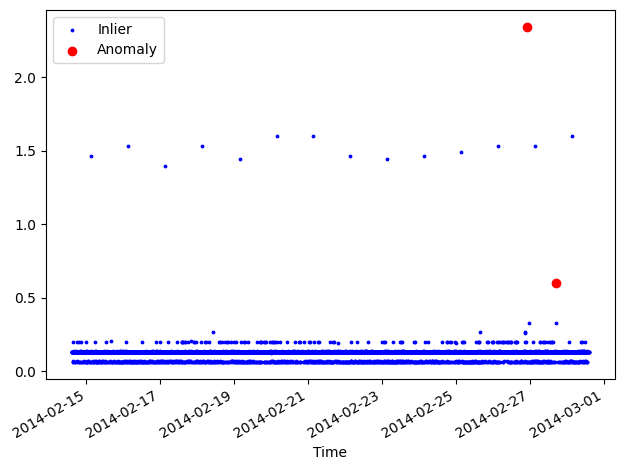

In [43]:
visualisation(cpu_data)


In [44]:
print(f"is the machine failure data set stationnary ? Answer : {is_time_series_stationary(machine_data)}.") 
print(f"is the ambiant failure data set stationnary ? Answer : {is_time_series_stationary(ambiant_data)}.") 
print(f"is the travel data set stationnary ? Answer : {is_time_series_stationary(travel_data)}.") 
print(f"is the CPU data set stationnary ? Answer : {is_time_series_stationary(cpu_data)}.") 
print(f"is the taxi data set stationnary ? Answer : {is_time_series_stationary(taxi_data)}.") 
print(f"is the twitter data set stationnary ? Answer : {is_time_series_stationary(twitter_data)}.") 

is the machine failure data set stationnary ? Answer : True.
is the ambiant failure data set stationnary ? Answer : True.
is the travel data set stationnary ? Answer : True.
is the CPU data set stationnary ? Answer : True.
is the taxi data set stationnary ? Answer : True.
is the twitter data set stationnary ? Answer : True.


---

# LSTM 

We apply the LSTM to the CPU dataset with 10 epocs

In [45]:
new_df = cpu_data.copy()
new_df = new_df.set_index('timestamp')

In [46]:
serie_cpu = serie(cpu_data)

In [47]:
train_cpu , test_cpu = train_test(serie_cpu)

In [48]:
train_standard_cpu , test_standard_cpu = standard(train_cpu , test_cpu)

In [49]:
X_train_cpu, y_train_cpu = create_dataset(train_standard_cpu[['value']], train_standard_cpu.value, 24)
X_test_cpu, y_test_cpu = create_dataset(test_standard_cpu[['value']], train_standard_cpu.value, 24)

In [50]:
model = create_and_train_lstm_model(X_train_cpu, y_train_cpu, epochs=10, batch_size=32, validation_split=0.1, shuffle=False)

Epoch 1/10
108/108 [==============================] - 3s 14ms/step - loss: 0.2492 - val_loss: 0.3225
Epoch 2/10
108/108 [==============================] - 1s 12ms/step - loss: 0.2462 - val_loss: 0.3217
Epoch 3/10
108/108 [==============================] - 1s 11ms/step - loss: 0.2456 - val_loss: 0.3211
Epoch 4/10
108/108 [==============================] - 1s 11ms/step - loss: 0.2454 - val_loss: 0.3206
Epoch 5/10
108/108 [==============================] - 1s 12ms/step - loss: 0.2453 - val_loss: 0.3205
Epoch 6/10
108/108 [==============================] - 1s 11ms/step - loss: 0.2452 - val_loss: 0.3205
Epoch 7/10
108/108 [==============================] - 1s 11ms/step - loss: 0.2451 - val_loss: 0.3203
Epoch 8/10
108/108 [==============================] - 1s 11ms/step - loss: 0.2450 - val_loss: 0.3203
Epoch 9/10
108/108 [==============================] - 1s 11ms/step - loss: 0.2450 - val_loss: 0.3202
Epoch 10/10
108/108 [==============================] - 1s 11ms/step - loss: 0.2449 - val_lo

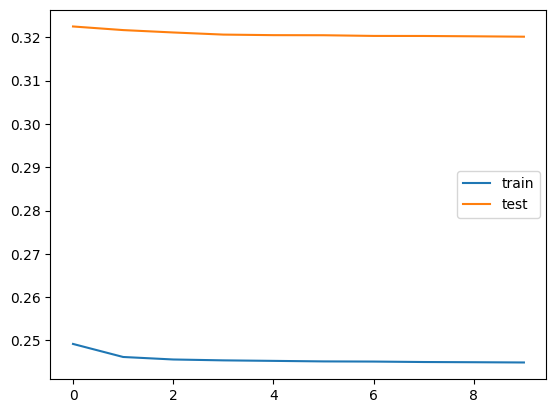

In [51]:
plt.plot(model[1].history['loss'], label='train')
plt.plot(model[1].history['val_loss'], label='test')
plt.legend();

In [52]:
test_score_df = detect_anomalies(X_test_cpu, model[0], test_standard_cpu, 24, threshold=0.65)

6/6 [==============================] - 0s 3ms/step


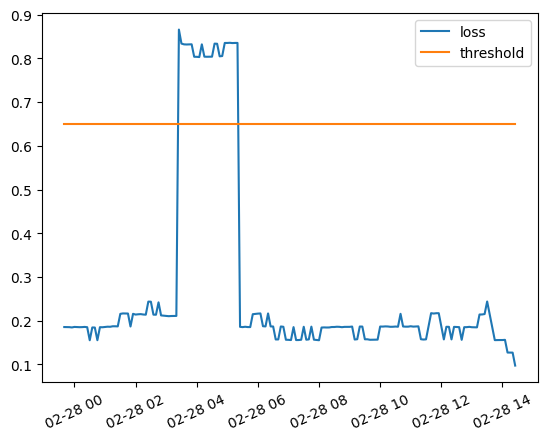

In [53]:
plot_loss(test_score_df)

In [54]:
df_with_ground_truth_cpu = mark_ground_truth(test_score_df, anomalies_cpu)

In [55]:
print_confusion_matrix_metrics_lm(df_with_ground_truth_cpu)

Confusion Matrix:
True Negatives (TN): 0
False Positives (FP): 0
False Negatives (FN): 24
True Positives (TP): 154
Recall (Sensitivity): 0.87
Specificity: 0.00


In [56]:
model_1 = create_and_train_lstm_model(X_train_cpu, y_train_cpu, epochs=100, batch_size=32, validation_split=0.1, shuffle=False)

Epoch 1/100
108/108 [==============================] - 3s 13ms/step - loss: 0.2490 - val_loss: 0.3231
Epoch 2/100
108/108 [==============================] - 1s 11ms/step - loss: 0.2460 - val_loss: 0.3219
Epoch 3/100
108/108 [==============================] - 1s 10ms/step - loss: 0.2456 - val_loss: 0.3211
Epoch 4/100
108/108 [==============================] - 1s 10ms/step - loss: 0.2454 - val_loss: 0.3208
Epoch 5/100
108/108 [==============================] - 1s 10ms/step - loss: 0.2452 - val_loss: 0.3206
Epoch 6/100
108/108 [==============================] - 1s 10ms/step - loss: 0.2452 - val_loss: 0.3205
Epoch 7/100
108/108 [==============================] - 1s 10ms/step - loss: 0.2451 - val_loss: 0.3204
Epoch 8/100
108/108 [==============================] - 1s 12ms/step - loss: 0.2450 - val_loss: 0.3202
Epoch 9/100
108/108 [==============================] - 1s 11ms/step - loss: 0.2449 - val_loss: 0.3202
Epoch 10/100
108/108 [==============================] - 1s 10ms/step - loss: 0.244

---

# MAD

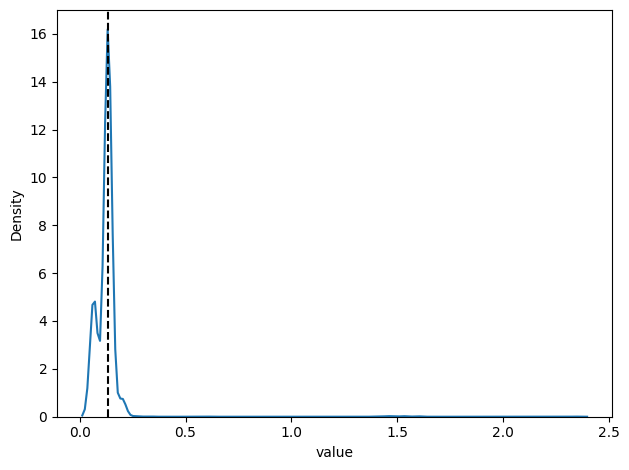

In [57]:
isnormal(cpu_data)

In [58]:
MAD_cpu_data_set =add_robust_z_score_column(cpu_data)

In [59]:
anomaly_predicted(MAD_cpu_data_set)

,timestamp,value,is_anomaly,z-score,anomaly_predicted
0,2014-02-14 14:30:00,0.132,1,-0.6745,1
1,2014-02-14 14:35:00,0.134,1,0.0000,1
2,2014-02-14 14:40:00,0.134,1,0.0000,1
3,2014-02-14 14:45:00,0.134,1,0.0000,1
4,2014-02-14 14:50:00,0.134,1,0.0000,1
...,...,...,...,...,...
4027,2014-02-28 14:05:00,0.132,1,-0.6745,1
4028,2014-02-28 14:10:00,0.134,1,0.0000,1
4029,2014-02-28 14:15:00,0.134,1,0.0000,1
4030,2014-02-28 14:20:00,0.134,1,0.0000,1


Confusion Matrix:
True Negatives (TN): 2
False Positives (FP): 0
False Negatives (FN): 1066
True Positives (TP): 2964
Recall (Sensitivity): 0.74
Specificity: 1.00


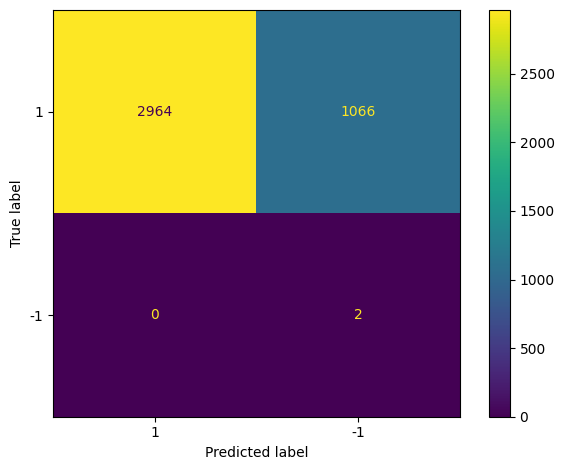

In [60]:
confusion_metrics(anomaly_predicted(MAD_cpu_data_set))
plot_confusion_matrix(anomaly_predicted(MAD_cpu_data_set))

---

# Isoltation forest

In [61]:
train_iso , test_iso = train_test_split(cpu_data, test_size=0.2, random_state=42)

Contamination level: 0.5
Confusion Matrix:
True Negatives (TN): 0
False Positives (FP): 0
False Negatives (FN): 238
True Positives (TP): 569
Recall (Sensitivity): 0.71
Specificity: 0.00


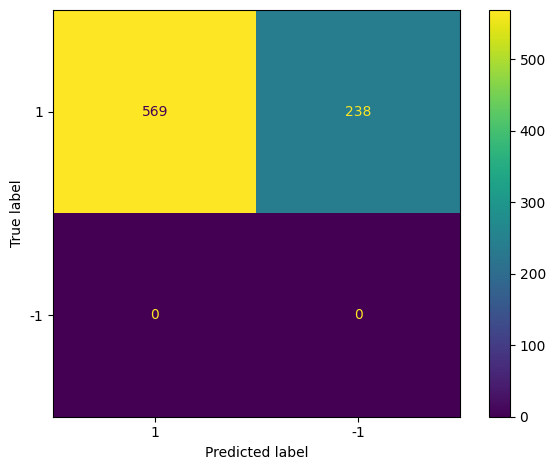

Contamination level: 0.05
Confusion Matrix:
True Negatives (TN): 0
False Positives (FP): 0
False Negatives (FN): 37
True Positives (TP): 770
Recall (Sensitivity): 0.95
Specificity: 0.00


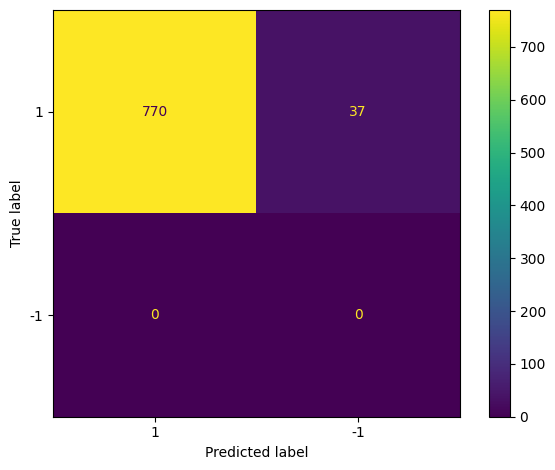

Contamination level: 0.005
Confusion Matrix:
True Negatives (TN): 0
False Positives (FP): 0
False Negatives (FN): 9
True Positives (TP): 798
Recall (Sensitivity): 0.99
Specificity: 0.00


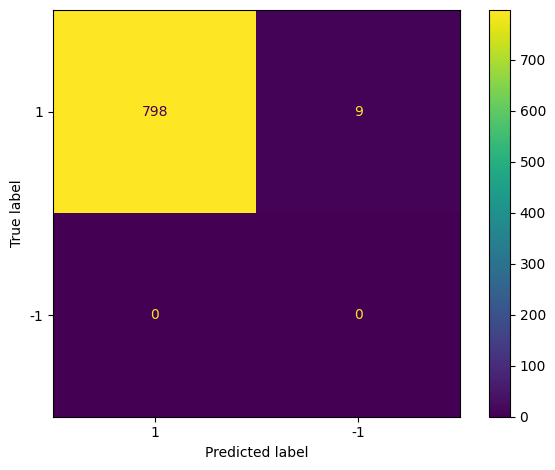

In [62]:
i = 0.5
while i >= 0.001:
    # Create isolation with the current contamination level
    prediction_result = createisolation(train_iso, test_iso, i)

    # Print metrics and plot confusion matrix
    print(f"Contamination level: {i}")
    confusion_metrics_iso(test_iso, prediction_result)
    plot_confusion_matrix_iso(test_iso, prediction_result)

    # Divide i by 10 for the next iteration
    i /= 10


---

# LOCAL OUTLIER FACTOR

Contamination level: 0.5


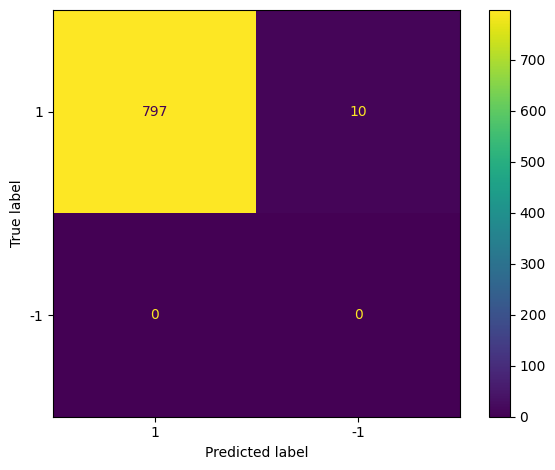

Confusion Matrix Metrics:
True Negatives (TN): 797
False Positives (FP): 10
False Negatives (FN): 0
True Positives (TP): 0
Recall (Sensitivity): 0.00
Specificity: 0.99
Contamination level: 0.05


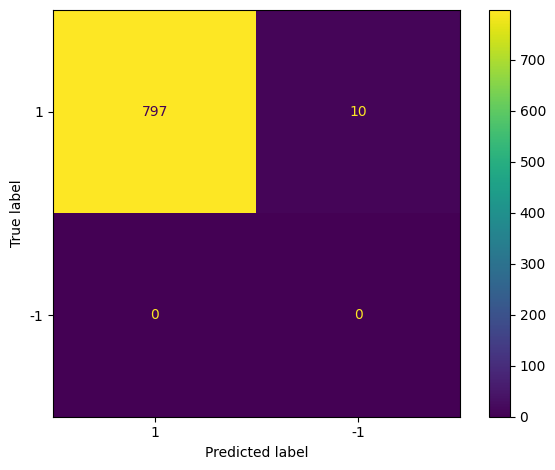

Confusion Matrix Metrics:
True Negatives (TN): 797
False Positives (FP): 10
False Negatives (FN): 0
True Positives (TP): 0
Recall (Sensitivity): 0.00
Specificity: 0.99
Contamination level: 0.005


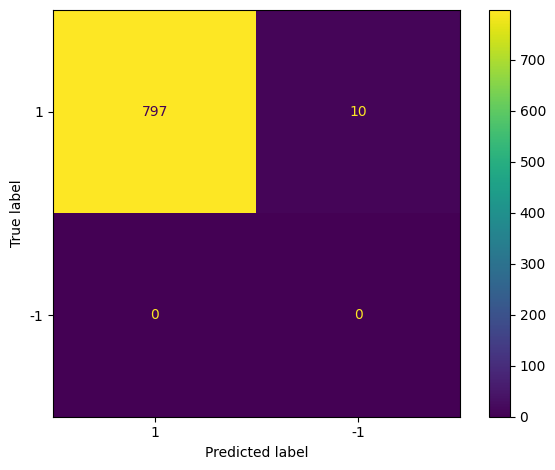

Confusion Matrix Metrics:
True Negatives (TN): 797
False Positives (FP): 10
False Negatives (FN): 0
True Positives (TP): 0
Recall (Sensitivity): 0.00
Specificity: 0.99


In [63]:
i = 0.5
while i >= 0.001:
    # Create isolation with the current contamination level
    cm = compute_confusion_matrix_local(train_iso , test_iso , i)

    # Print metrics and plot confusion matrix
    print(f"Contamination level: {i}")
    display_confusion_matrix_local(cm)
    print_confusion_matrix_metrics_local(cm)

    # Divide i by 10 for the next iteration
    i /= 10

---

# ATDK

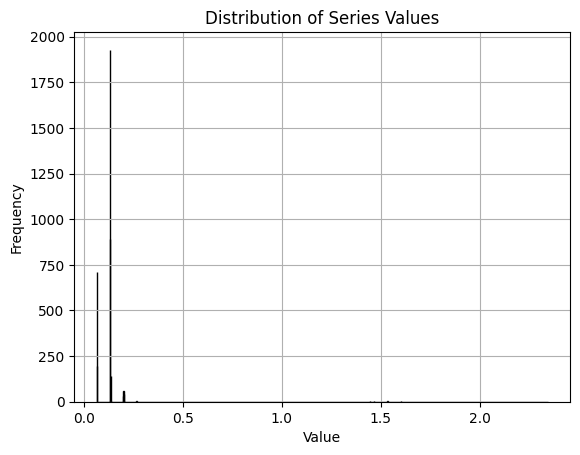

In [ ]:
histogram(serie_cpu)

In [64]:
data = cpu_data.copy()
data.drop('is_anomaly' , axis = 1)
threshold_ad = ThresholdAD(high=0.2, low=0)
anomalies = threshold_ad.detect(serie_cpu)
L = anomalies['value'].values
T = convert(L)
data['is_anomaly'] = T

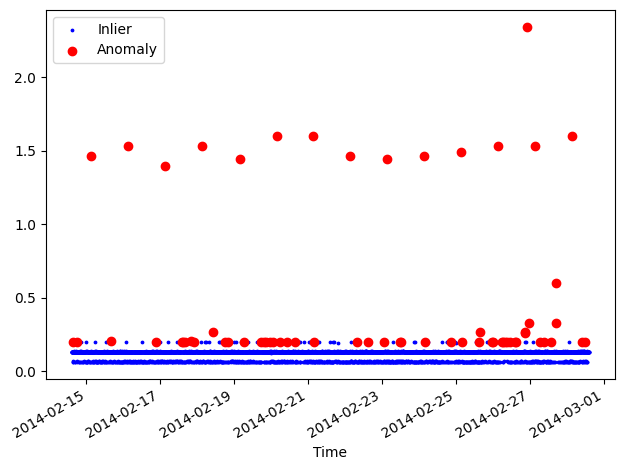

In [65]:
visualisation(data)

In [66]:
data_2 = cpu_data.copy()
data_2.drop('is_anomaly' , axis = 1)
quantile_ad = QuantileAD(high=0.99, low=0.01)
anomalies = quantile_ad.fit_detect(serie_cpu)
L_2 = anomalies['value'].values
T_2 = convert(L_2)
data_2['is_anomaly'] = T_2

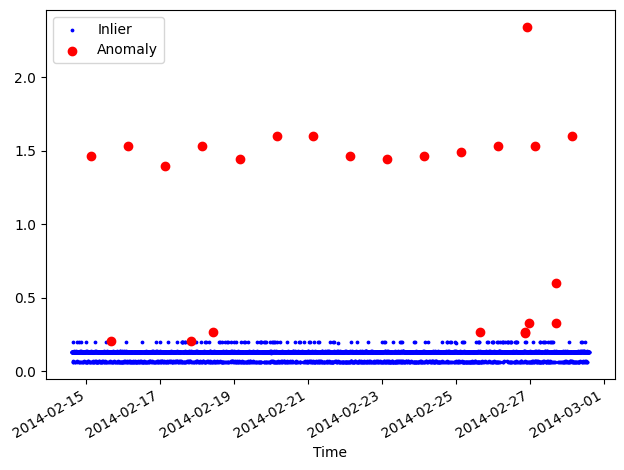

In [67]:
visualisation(data_2)

In [68]:
data_3 = cpu_data.copy()
data_3.drop('is_anomaly' , axis = 1)
iqr_ad = InterQuartileRangeAD(c=1.5)
anomalies = iqr_ad.fit_detect(serie_cpu)
L_3 = anomalies['value'].values
T_3 = convert(L_3)
data_3['is_anomaly'] = T_3

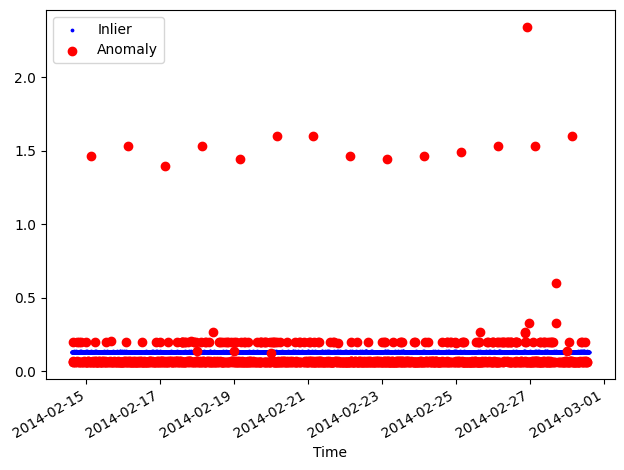

In [69]:
visualisation(data_3)

---

# PROPHET

In [77]:
cpu_prophet = datasetprophet(cpu_data)

In [82]:
model_prophet_cpu = Prophet(interval_width = 0.99 , yearly_seasonality = False , weekly_seasonality = False)
model_prophet_cpu.fit(cpu_prophet)


23:21:40 - cmdstanpy - INFO - Chain [1] start processing
23:21:40 - cmdstanpy - INFO - Chain [1] done processing


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


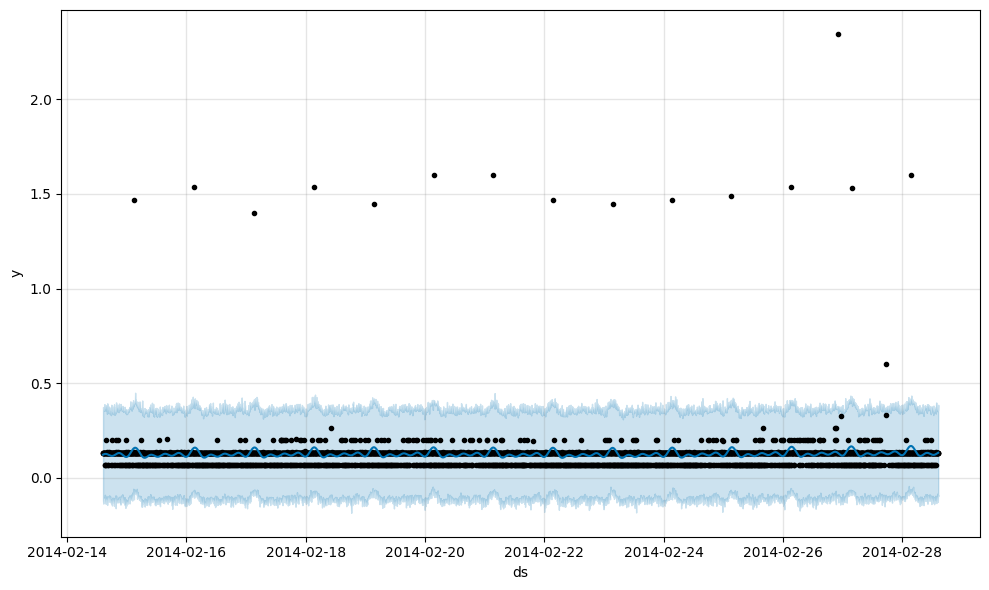

In [83]:
forecast(cpu_prophet,model_prophet_cpu)

In [84]:
performance_cpu = evaluation(cpu_prophet,model_prophet_cpu)

MAE is equal to  0.030995263362411055 
MAPE is equal to  0.29020802846280497 


In [89]:
performance_cpu['is_anomaly'] = cpu_data['is_anomaly'].values

In [91]:
confusion_metrics(performance_cpu)

Confusion Matrix:
True Negatives (TN): 2
False Positives (FP): 0
False Negatives (FN): 14
True Positives (TP): 4016
Recall (Sensitivity): 1.00
Specificity: 1.00


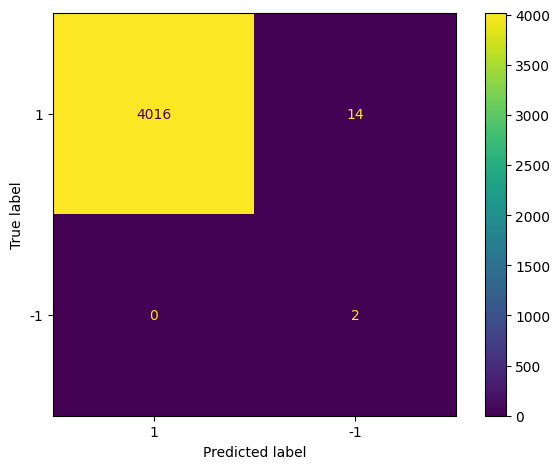

In [92]:
plot_confusion_matrix(performance_cpu)

---

---

---

# TWITTER DATA SET

In [93]:
twitter_data = importdataset("Twitter_volume_UPS.csv")

In [94]:
twitter_data = timestamp(twitter_data)

In [95]:
twitter_data  = label(twitter_data , anomalie__twitter)

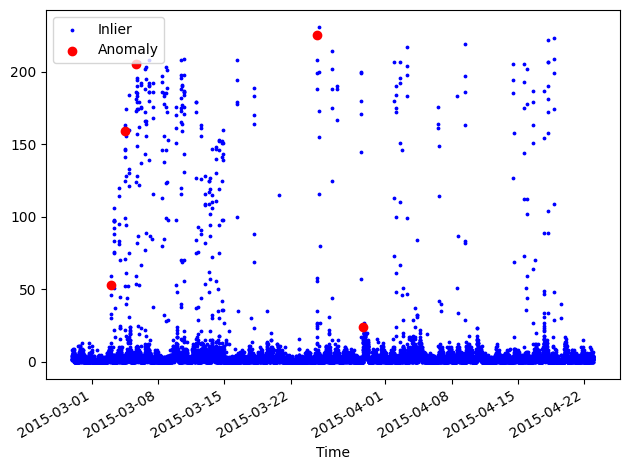

In [96]:
visualisation(twitter_data)

---

# LSTM 

In [97]:
new_df_1 = twitter_data.copy()
new_df_1 = new_df_1.set_index('timestamp')

In [98]:
serie_twitter = serie(twitter_data)
train_twitter , test_twitter = train_test(serie_twitter)

In [99]:
train_standard_twitter , test_standard_twitter = standard(train_twitter , test_twitter)

In [100]:
X_train_twitter, y_train_twitter = create_dataset(train_standard_twitter[['value']], train_standard_twitter.value, 24)
X_test_twitter, y_test_twitter = create_dataset(test_standard_twitter[['value']], train_standard_twitter.value, 24)

Epoch 1/10
424/424 [==============================] - 6s 11ms/step - loss: 0.2253 - val_loss: 0.2394
Epoch 2/10
424/424 [==============================] - 4s 10ms/step - loss: 0.2168 - val_loss: 0.2384
Epoch 3/10
424/424 [==============================] - 4s 10ms/step - loss: 0.2147 - val_loss: 0.2383
Epoch 4/10
424/424 [==============================] - 4s 10ms/step - loss: 0.2141 - val_loss: 0.2383
Epoch 5/10
424/424 [==============================] - 4s 10ms/step - loss: 0.2139 - val_loss: 0.2383
Epoch 6/10
424/424 [==============================] - 4s 10ms/step - loss: 0.2136 - val_loss: 0.2378
Epoch 7/10
424/424 [==============================] - 4s 10ms/step - loss: 0.2134 - val_loss: 0.2380
Epoch 8/10
424/424 [==============================] - 4s 10ms/step - loss: 0.2134 - val_loss: 0.2378
Epoch 9/10
424/424 [==============================] - 4s 10ms/step - loss: 0.2132 - val_loss: 0.2376
Epoch 10/10
424/424 [==============================] - 4s 10ms/step - loss: 0.2131 - val_lo

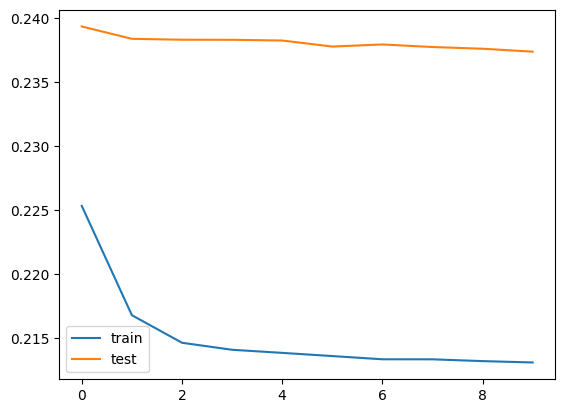

In [101]:
model_twitter = create_and_train_lstm_model(X_train_twitter, y_train_twitter, epochs=10, batch_size=32, validation_split=0.1, shuffle=False)
plt.plot(model_twitter[1].history['loss'], label='train')
plt.plot(model_twitter[1].history['val_loss'], label='test')
plt.legend()

25/25 [==============================] - 0s 3ms/step


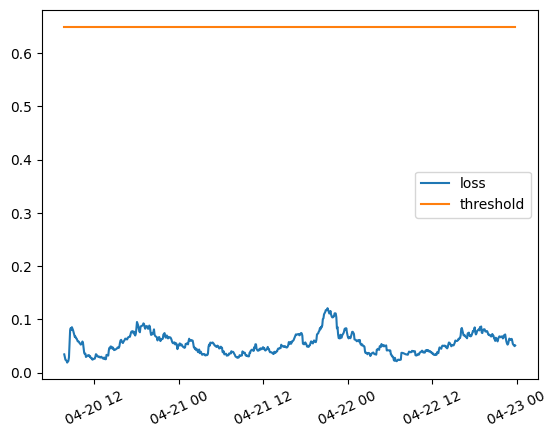

In [103]:
test_score_twitter = detect_anomalies(X_test_twitter, model_twitter[0], test_standard_twitter, 24, threshold=0.65)
plot_loss(test_score_twitter)

# MAD

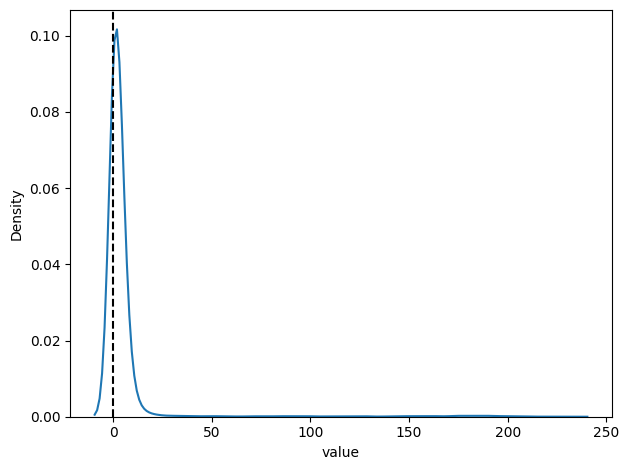

In [104]:
isnormal(twitter_data)

In [105]:
MAD_twitter_data_set =add_robust_z_score_column(twitter_data)

In [106]:
anomaly_predicted(MAD_twitter_data_set)

,timestamp,value,is_anomaly,z-score,anomaly_predicted
0,2015-02-26 21:42:53,2,1,0.00000,1
1,2015-02-26 21:47:53,2,1,0.00000,1
2,2015-02-26 21:52:53,4,1,0.67450,1
3,2015-02-26 21:57:53,3,1,0.33725,1
4,2015-02-26 22:02:53,5,1,1.01175,1
...,...,...,...,...,...
15861,2015-04-22 23:27:53,3,1,0.33725,1
15862,2015-04-22 23:32:53,2,1,0.00000,1
15863,2015-04-22 23:37:53,2,1,0.00000,1
15864,2015-04-22 23:42:53,3,1,0.33725,1


Confusion Matrix:
True Negatives (TN): 5
False Positives (FP): 0
False Negatives (FN): 609
True Positives (TP): 15252
Recall (Sensitivity): 0.96
Specificity: 1.00


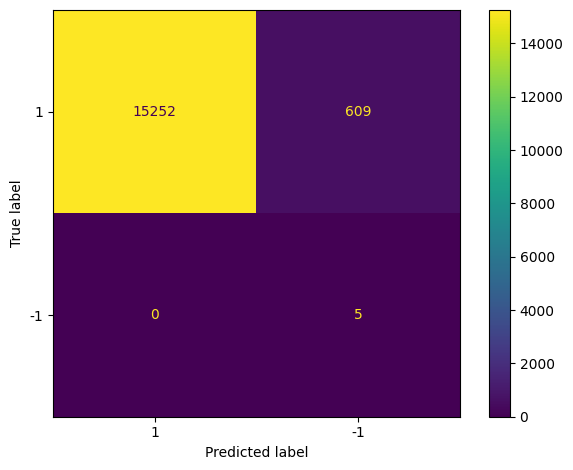

In [107]:
confusion_metrics(anomaly_predicted(MAD_twitter_data_set))
plot_confusion_matrix(anomaly_predicted(MAD_twitter_data_set))

---

# Isoltation forest

In [108]:
train_twitter , test_twitter = train_test_split(twitter_data, test_size=0.2, random_state=42)

Contamination level: 0.1
Confusion Matrix:
True Negatives (TN): 0
False Positives (FP): 0
False Negatives (FN): 299
True Positives (TP): 2875
Recall (Sensitivity): 0.91
Specificity: 0.00


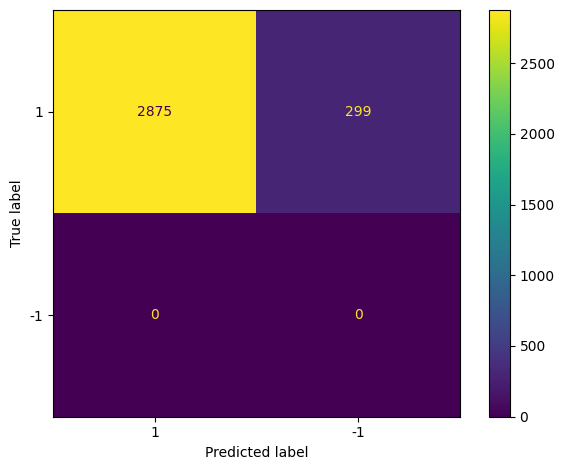

In [109]:
prediction_result_twitter = createisolation(train_twitter , test_twitter, 0.1)


print(f"Contamination level: {0.1}")
confusion_metrics_iso(test_twitter, prediction_result_twitter)
plot_confusion_matrix_iso(test_twitter, prediction_result_twitter)

Contamination level: 0.0005


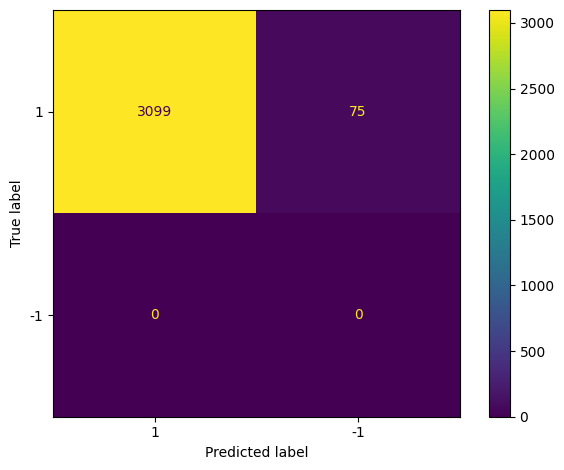

Confusion Matrix Metrics:
True Negatives (TN): 3099
False Positives (FP): 75
False Negatives (FN): 0
True Positives (TP): 0
Recall (Sensitivity): 0.00
Specificity: 0.98


In [110]:
# Create isolation with the current contamination level
cm_1 = compute_confusion_matrix_local(train_twitter , test_twitter , 0.1)

# Print metrics and plot confusion matrix
print(f"Contamination level: {i}")
display_confusion_matrix_local(cm_1)
print_confusion_matrix_metrics_local(cm_1)

---

---

---

# TAXI DATA SET

In [111]:
taxi_data = importdataset("nyc_taxi.csv")

In [112]:
taxi_data = timestamp(taxi_data)

In [113]:
taxi_data = label(taxi_data, anomalie_taxi)

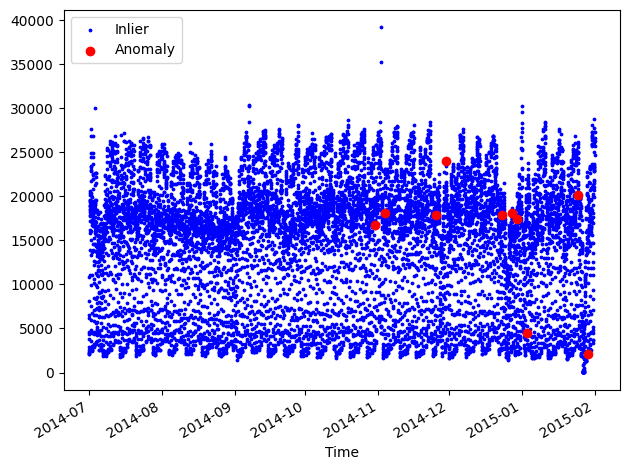

In [114]:
visualisation(taxi_data)

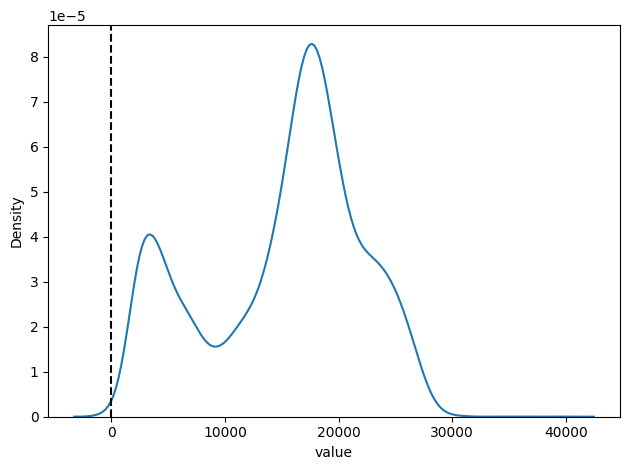

In [120]:
isnormal(taxi_data)

Confusion Matrix:
True Negatives (TN): 0
False Positives (FP): 10
False Negatives (FN): 1
True Positives (TP): 10309
Recall (Sensitivity): 1.00
Specificity: 0.00


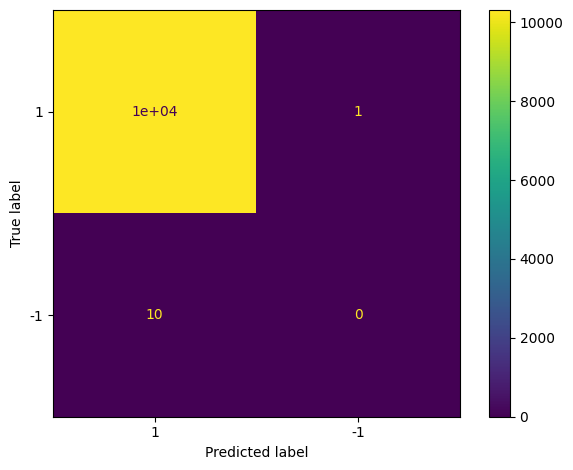

In [121]:
MAD_taxi_data_set =add_robust_z_score_column(taxi_data)
anomaly_predicted(MAD_taxi_data_set)
confusion_metrics(anomaly_predicted(MAD_taxi_data_set))
plot_confusion_matrix(anomaly_predicted(MAD_taxi_data_set))

---

---

---

---

# TRAVEL DATA SET

In [115]:
travel_data = importdataset("TravelTime_451.csv")

In [116]:
travel_data = timestamp(travel_data)

In [118]:
travel_data = label(travel_data, anomalie_traval)

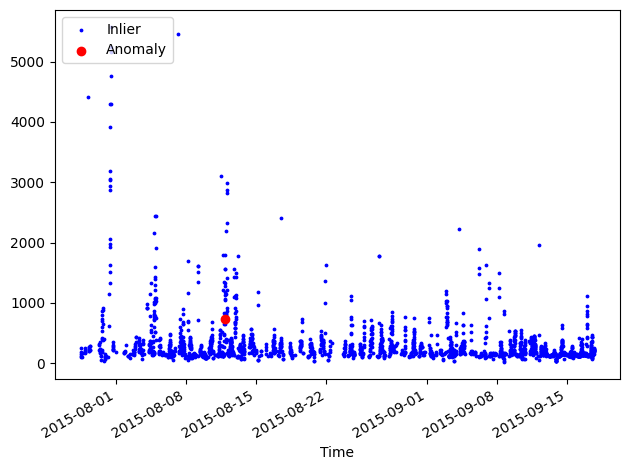

In [119]:
visualisation(travel_data)

In [124]:
train_travel , test_travel = train_test_split(travel_data, test_size=0.2, random_state=42)

Contamination level: 0.1
Confusion Matrix:
True Negatives (TN): 0
False Positives (FP): 0
False Negatives (FN): 41
True Positives (TP): 392
Recall (Sensitivity): 0.91
Specificity: 0.00


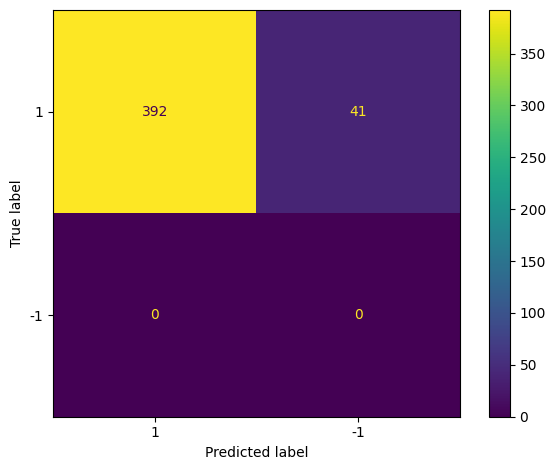

In [125]:
prediction_result_travel = createisolation(train_travel , test_travel, 0.1)


print(f"Contamination level: {0.1}")
confusion_metrics_iso(test_travel, prediction_result_travel)
plot_confusion_matrix_iso(test_travel, prediction_result_travel)

---